In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import math

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from sklearn.metrics import explained_variance_score, r2_score, mean_squared_error
from sklearn.metrics import classification_report,confusion_matrix 



In [2]:
df = pd.read_csv("insurance.csv")
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


Indeksy zmiennych, które należy usunąć: []


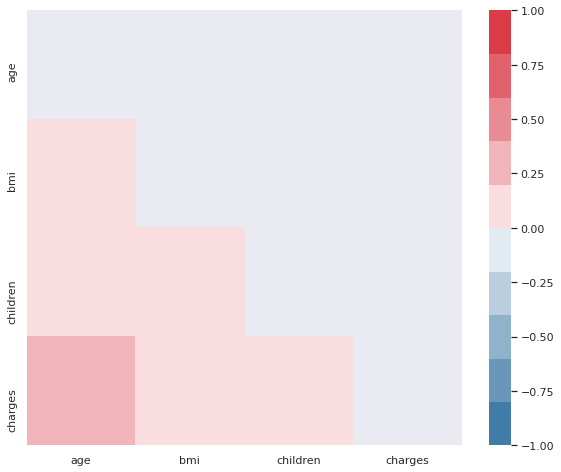

In [3]:
correlation_matrix = np.round(df.corr(),3)

sns.set(rc={'figure.figsize':(10,8)}) 
color_map = sns.diverging_palette(240, 10, n=10)
mask = np.triu(np.ones_like(correlation_matrix), k=0)
sns.heatmap(correlation_matrix,vmin=-1.,vmax=1.,cmap=color_map,mask=mask,square=True) 
pass

M = np.tril(correlation_matrix.to_numpy(),k=-1) 
r,c = np.where(np.abs(M)>=0.8)
c=np.unique(c)
print(f'Indeksy zmiennych, które należy usunąć: {c}' )


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe6b827f2b0>,
      dtype=object)

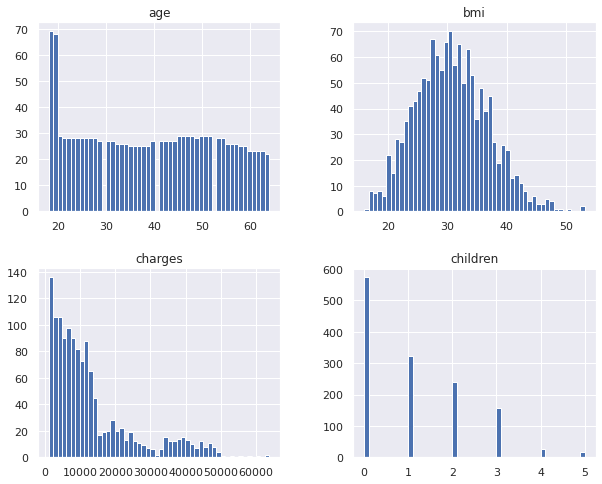

In [4]:
df.hist(bins=50)

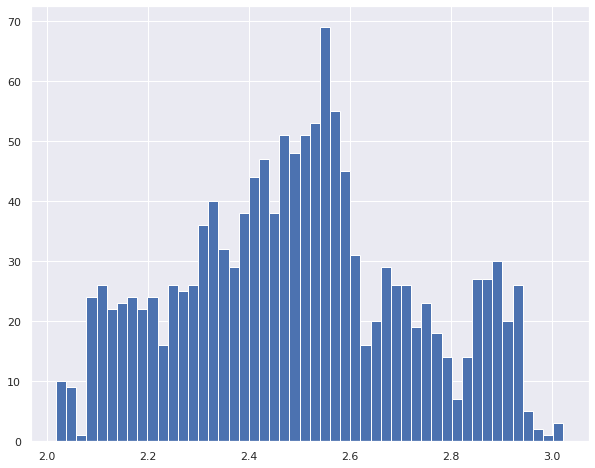

In [5]:
df['charges'] = df['charges']**0.1

df['charges'].hist(bins=50)

In [6]:
new = np.array(df['age'])
new = new.reshape(-1,1)

scaler = StandardScaler()
scaler.fit(new)
df['age'] = scaler.transform(new)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe6b839c580>,
      dtype=object)

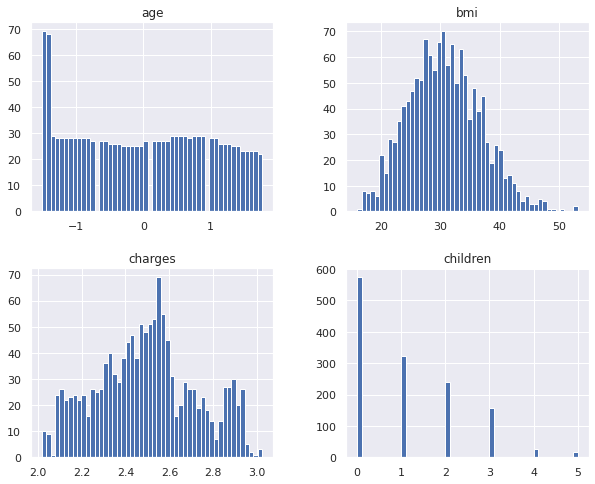

In [7]:
df.hist(bins=50)

In [8]:
df_dummy = pd.get_dummies(df, columns=['sex','smoker','region'])
df_dummy

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,-1.438764,27.900,0,2.646975,1,0,0,1,0,0,0,1
1,-1.509965,33.770,1,2.107137,0,1,1,0,0,0,1,0
2,-0.797954,33.000,3,2.316492,0,1,1,0,0,0,1,0
3,-0.441948,22.705,0,2.717763,0,1,1,0,0,1,0,0
4,-0.513149,28.880,0,2.284209,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,0.768473,30.970,3,2.526579,0,1,1,0,0,1,0,0
1334,-1.509965,31.920,0,2.159535,1,0,1,0,1,0,0,0
1335,-1.509965,36.850,0,2.095146,1,0,1,0,0,0,1,0
1336,-1.296362,25.800,0,2.139317,1,0,1,0,0,0,0,1


In [9]:
df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1338 non-null   float64
 1   bmi               1338 non-null   float64
 2   children          1338 non-null   int64  
 3   charges           1338 non-null   float64
 4   sex_female        1338 non-null   uint8  
 5   sex_male          1338 non-null   uint8  
 6   smoker_no         1338 non-null   uint8  
 7   smoker_yes        1338 non-null   uint8  
 8   region_northeast  1338 non-null   uint8  
 9   region_northwest  1338 non-null   uint8  
 10  region_southeast  1338 non-null   uint8  
 11  region_southwest  1338 non-null   uint8  
dtypes: float64(3), int64(1), uint8(8)
memory usage: 52.4 KB


In [10]:
X = df_dummy.drop(columns = ['charges', 'sex_female', 'smoker_no', 'region_southwest']).dropna()
Y = df_dummy['charges']

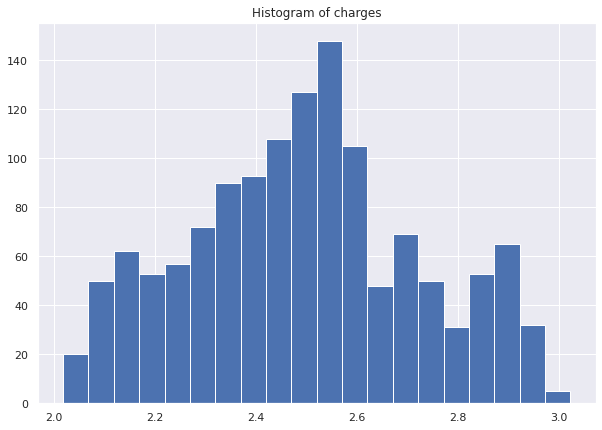

In [11]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 10, 7
plt.hist(Y, bins=20)
_ = plt.title("Histogram of charges")

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [13]:
# Model_1 Random_forest

def grid_combination(grid):
    total_params = 1 
    for par in grid:
        total_params  = total_params * len(grid[par])
    return total_params

# Random search

param_grid = {"max_depth": [2,5,8, 10, None],
            "n_estimators":[10,20,50,100],
            "min_samples_leaf":[2,4,8,20]
             }
print(grid_combination(param_grid))

crf = RandomForestRegressor(random_state=2042)
random_search = RandomizedSearchCV(crf, param_distributions=param_grid, cv=4,n_iter=30,verbose=0, random_state=2042)
random_search.fit(X_train, Y_train)

ranks = random_search.cv_results_['rank_test_score']
ranks.sort()
n = 6
for i in range(n):
    print(random_search.cv_results_['params'][ranks[i]])

# # Grid search

param_grid = {"max_depth": [2, 5,8, None],
            "n_estimators":[10,20, 50],
            "min_samples_leaf":[2,4, 8, 20]
             }
print(grid_combination(param_grid))

grid_search = GridSearchCV(crf, param_grid=param_grid, cv=5,verbose=0)
grid_search.fit(X_train, Y_train)
grid_search.best_params_

80
{'n_estimators': 10, 'min_samples_leaf': 8, 'max_depth': 8}
{'n_estimators': 10, 'min_samples_leaf': 20, 'max_depth': 2}
{'n_estimators': 50, 'min_samples_leaf': 2, 'max_depth': 2}
{'n_estimators': 10, 'min_samples_leaf': 4, 'max_depth': None}
{'n_estimators': 20, 'min_samples_leaf': 8, 'max_depth': 5}
{'n_estimators': 10, 'min_samples_leaf': 20, 'max_depth': 5}
48


{'max_depth': 8, 'min_samples_leaf': 8, 'n_estimators': 50}

In [14]:
model_1 = RandomForestRegressor(max_depth = 5, n_estimators =50, min_samples_leaf=2, random_state=2042)
model_1.fit(X_train, Y_train)


RandomForestRegressor(max_depth=5, min_samples_leaf=2, n_estimators=50,
                      random_state=2042)

In [15]:
predict_1 = model_1.predict(X_test)

print('Wynik na zbiorze testowym explained variance score:', explained_variance_score(Y_test,predict_1))
print('Wynik na zbiorze testowym r2:', r2_score(Y_test,predict_1))
print('Wynik na zbiorze testowym mean_squared_error:', mean_squared_error(Y_test,predict_1))

Wynik na zbiorze testowym explained variance score: 0.8599416224744104
Wynik na zbiorze testowym r2: 0.8599220491832322
Wynik na zbiorze testowym mean_squared_error: 0.008096749424270504


In [16]:
model_r2 = []

for iteration in range(10):
    print(iteration)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    clf = RandomForestRegressor(max_depth = 5, n_estimators =50, min_samples_leaf=2, random_state=2042)
    clf.fit(x_train, y_train)
    predict = clf.predict(x_test)
    model_r2.append(r2_score(y_test, predict))

print("Średni wynik modelu na zbiorze testowym r_2: ", np.mean(model_r2))

0
1
2
3
4
5
6
7
8
9
Średni wynik modelu na zbiorze testowym r_2:  0.817175083810907


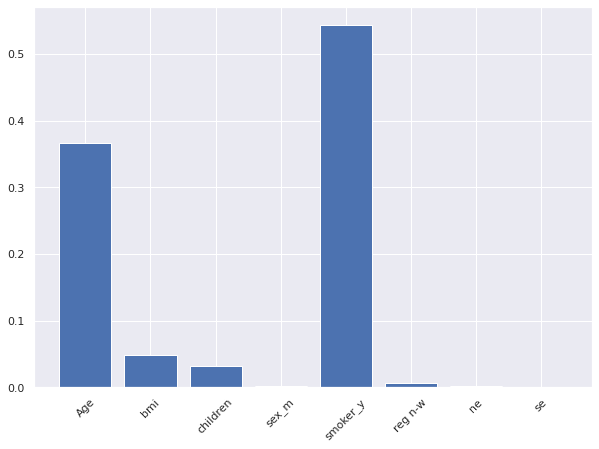

In [17]:
model_1.feature_importances_
feature_list = ['Age', 'bmi', 'children', 'sex_m', 'smoker_y','reg n-w', 'ne', 'se']

plt.bar(feature_list,model_1.feature_importances_)
plt.xticks(rotation=45)
pass

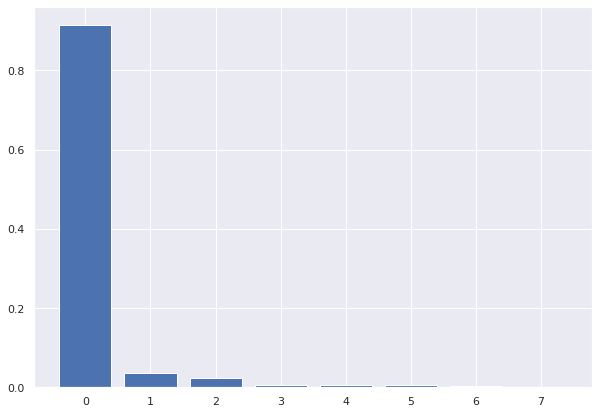

In [18]:
pca = PCA()
pca.fit(X_train)

plt.bar(range(pca.n_components_),pca.explained_variance_ratio_)
pass


n_pca_comp=8
X_pca_train = pca.transform(X_train)[:,:n_pca_comp+1]
X_pca_test = pca.transform(X_test)[:,:n_pca_comp+1]

In [19]:
model_2 = RandomForestRegressor(max_depth = 5, n_estimators =50, min_samples_leaf=2, random_state=2042)
model_2.fit(X_pca_train, Y_train)

predict_2 = model_2.predict(X_pca_test)

print('Wynik na zbiorze testowym explained variance score:', explained_variance_score(Y_test,predict_2))
print('Wynik na zbiorze testowym r2:', r2_score(Y_test,predict_2))
print('Wynik na zbiorze testowym mean_squared_error:', mean_squared_error(Y_test,predict_2))

Wynik na zbiorze testowym explained variance score: 0.8571128408110794
Wynik na zbiorze testowym r2: 0.8570602363444998
Wynik na zbiorze testowym mean_squared_error: 0.008262167188588647


In [20]:
# Sprawdzenie modelu na danych treningowych

predict_2_tr = model_2.predict(X_pca_train)

print('Wynik na zbiorze treningowym explained variance score:', explained_variance_score(Y_train,predict_2_tr))
print('Wynik na zbiorze treningowym r2:', r2_score(Y_train,predict_2_tr))
print('Wynik na zbiorze treningowym mean_squared_error:', mean_squared_error(Y_train,predict_2_tr))


Wynik na zbiorze treningowym explained variance score: 0.8713321155099117
Wynik na zbiorze treningowym r2: 0.871319993465821
Wynik na zbiorze treningowym mean_squared_error: 0.006534683660677777


In [21]:
# Model_2 XGboost

def grid_combination(grid):
    total_params = 1 
    for par in grid:
        total_params  = total_params * len(grid[par])
    return total_params

# Random search

param_grid = {"max_depth": [2,5,8, 10, None],
            "n_estimators":[10,20,50,100],
            "learning_rate":[0.001,0.003,0.01,0.03, 0.05, 0.1, 0.3, 0.5]
             }
print(grid_combination(param_grid))

crf_2 = xgb.XGBRegressor()
random_search = RandomizedSearchCV(crf_2, param_distributions=param_grid, cv=4,n_iter=30,verbose=0, random_state=2042)
random_search.fit(X_train, Y_train)

ranks = random_search.cv_results_['rank_test_score']
ranks.sort()
n = 6
for i in range(n):
    print(random_search.cv_results_['params'][ranks[i]])

# Grid search

param_grid = {"max_depth": [2,8,10, None],
            "n_estimators":[10,20, 50, 100],
            "learning_rate":[0.001,0.01,0.05, 0.1, 0.3]
             }
print(grid_combination(param_grid))

grid_search = GridSearchCV(crf_2, param_grid=param_grid, cv=5,verbose=0)
grid_search.fit(X_train, Y_train)
grid_search.best_params_

160
{'n_estimators': 10, 'max_depth': 10, 'learning_rate': 0.001}
{'n_estimators': 50, 'max_depth': None, 'learning_rate': 0.01}
{'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.05}
{'n_estimators': 20, 'max_depth': 8, 'learning_rate': 0.1}
{'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.3}
{'n_estimators': 10, 'max_depth': 8, 'learning_rate': 0.05}
80


{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}

In [22]:
model_2 = xgb.XGBRegressor(max_depth = 2, n_estimators =100, learning_rate=0.1, random_state=2042)
model_2.fit(X_train, Y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=2042,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
predict_2 = model_2.predict(X_test)

print('Wynik na zbiorze treningowym explained variance score:', explained_variance_score(Y_test,predict_2))
print('Wynik na zbiorze treningowym r2:', r2_score(Y_test,predict_2))
print('Wynik na zbiorze treningowym mean_squared_error:', mean_squared_error(Y_test,predict_2))

Wynik na zbiorze treningowym explained variance score: 0.8564199091708355
Wynik na zbiorze treningowym r2: 0.8563644119143801
Wynik na zbiorze treningowym mean_squared_error: 0.008302387052036925


In [24]:
model_r2 = []

for iteration in range(10):
    print(iteration)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    clf = xgb.XGBRegressor(max_depth = 2, n_estimators =20, learning_rate=0.3, random_state=2042)
    clf.fit(x_train, y_train)
    predict = clf.predict(x_test)
    model_r2.append(r2_score(y_test, predict))

print("Średni wynik modelu na zbiorze testowym r_2:", np.mean(model_r2))

0
1
2
3
4
5
6
7
8
9
Średni wynik modelu na zbiorze testowym r_2: 0.8441752461642429


In [25]:
# Sprawdzenie modelu na danych treningowych

predict_2_tr = model_2.predict(X_train)

print('Wynik na zbiorze treningowym explained variance score:', explained_variance_score(Y_train,predict_2_tr))
print('Wynik na zbiorze treningowym r2:', r2_score(Y_train,predict_2_tr))
print('Wynik na zbiorze treningowym mean_squared_error:', mean_squared_error(Y_train,predict_2_tr))


Wynik na zbiorze treningowym explained variance score: 0.851722366695312
Wynik na zbiorze treningowym r2: 0.8517222118081427
Wynik na zbiorze treningowym mean_squared_error: 0.007529906671876068


In [26]:
# Model 3 SVR

model_3 = SVR(kernel='linear')
model_3.fit(X_train, Y_train)

predict_3 = model_3.predict(X_test)

print('Wynik na zbiorze testowym explained variance score:', explained_variance_score(Y_test,predict_3))
print('Wynik na zbiorze testowym r2:', r2_score(Y_test,predict_3))
print('Wynik na zbiorze testowym mean_squared_error:', mean_squared_error(Y_test,predict_3))

Wynik na zbiorze testowym explained variance score: 0.807132508987501
Wynik na zbiorze testowym r2: 0.8064698396009319
Wynik na zbiorze testowym mean_squared_error: 0.011186380195123203


In [27]:
model_r2 = []

for iteration in range(10):
    print(iteration)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    clf_3 = SVR(kernel='linear')
    clf_3.fit(x_train, y_train)
    predict_3 = clf_3.predict(x_test)
    model_r2.append(r2_score(y_test, predict_3))

print("Średni wynik modelu na zbiorze testowym r_2:", np.mean(model_r2))

0
1
2
3
4
5
6
7
8
9
Średni wynik modelu na zbiorze testowym r_2: 0.7712291259372697


In [28]:
# Sprawdzenie modelu na danych treningowych

predict_3_tr = model_3.predict(X_train)

print('Wynik na zbiorze treningowym explained variance score:', explained_variance_score(Y_train,predict_3_tr))
print('Wynik na zbiorze treningowym r2:', r2_score(Y_train,predict_3_tr))
print('Wynik na zbiorze treningowym mean_squared_error:', mean_squared_error(Y_train,predict_3_tr))


Wynik na zbiorze treningowym explained variance score: 0.7567531635663263
Wynik na zbiorze treningowym r2: 0.7566385317139327
Wynik na zbiorze treningowym mean_squared_error: 0.012358487175123948


In [29]:
#  Model 4 Regresja

model_4 = LinearRegression()
model_4.fit(X_train, Y_train)

predict_4 = model_4.predict(X_test)

print('Wynik na zbiorze testowym explained variance score:', explained_variance_score(Y_test,predict_4))
print('Wynik na zbiorze testowym r2:', r2_score(Y_test,predict_4))
print('Wynik na zbiorze testowym mean_squared_error:', mean_squared_error(Y_test,predict_4))

Wynik na zbiorze testowym explained variance score: 0.8120867818946748
Wynik na zbiorze testowym r2: 0.811026068585969
Wynik na zbiorze testowym mean_squared_error: 0.010923022227674778


In [30]:
model_r2 = []

for iteration in range(10):
    print(iteration)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    clf_4 = LinearRegression()
    clf_4.fit(x_train, y_train)
    predict_4 = clf_4.predict(x_test)
    model_r2.append(r2_score(y_test, predict_4))

print("Średni wynik modelu na zbiorze testowym r_2:", np.mean(model_r2))

0
1
2
3
4
5
6
7
8
9
Średni wynik modelu na zbiorze testowym r_2: 0.7644875796287595


In [31]:
# Sprawdzenie modelu na danych treningowych

predict_4_tr = model_2.predict(X_train)

print('Wynik na zbiorze treningowym explained variance score:', explained_variance_score(Y_train,predict_4_tr))
print('Wynik na zbiorze treningowym r2:', r2_score(Y_train,predict_4_tr))
print('Wynik na zbiorze treningowym mean_squared_error:', mean_squared_error(Y_train,predict_4_tr))


Wynik na zbiorze treningowym explained variance score: 0.851722366695312
Wynik na zbiorze treningowym r2: 0.8517222118081427
Wynik na zbiorze treningowym mean_squared_error: 0.007529906671876068


In [32]:
#  Model 5 KNN

model_5 = KNeighborsRegressor(n_neighbors = 8, metric = 'manhattan')
model_5.fit(X_train, Y_train)

predict_5 = model_5.predict(X_test)

print('Wynik na zbiorze testowym explained variance score:', explained_variance_score(Y_test,predict_5))
print('Wynik na zbiorze testowym r2:', r2_score(Y_test,predict_5))
print('Wynik na zbiorze testowym mean_squared_error:', mean_squared_error(Y_test,predict_5))

Wynik na zbiorze testowym explained variance score: 0.6112679850214218
Wynik na zbiorze testowym r2: 0.5969187250438226
Wynik na zbiorze testowym mean_squared_error: 0.02329879943207294


In [33]:
model_r2 = []

for iteration in range(10):
    print(iteration)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    clf_5 = KNeighborsRegressor(n_neighbors = 8, metric = 'manhattan')
    clf_5.fit(x_train, y_train)
    predict_5 = clf_5.predict(x_test)
    model_r2.append(r2_score(y_test, predict_5))

print("Średni wynik modelu na zbiorze testowym r_2:", np.mean(model_r2))

0
1
2
3
4
5
6
7
8
9
Średni wynik modelu na zbiorze testowym r_2: 0.5512282524327486


In [34]:
# Sprawdzenie modelu na danych treningowych

predict_5_tr = model_5.predict(X_train)

print('Wynik na zbiorze treningowym explained variance score:', explained_variance_score(Y_train,predict_5_tr))
print('Wynik na zbiorze treningowym r2:', r2_score(Y_train,predict_5_tr))
print('Wynik na zbiorze treningowym mean_squared_error:', mean_squared_error(Y_train,predict_5_tr))


Wynik na zbiorze treningowym explained variance score: 0.6681945377687268
Wynik na zbiorze treningowym r2: 0.6543129689814444
Wynik na zbiorze treningowym mean_squared_error: 0.017554828089825756
